In [72]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import datetime
import time
from collections import Counter
import csv
import seaborn as sns
import duckdb
import folium

In [73]:
#Para cada usuario (id), vai existir um grafo onde os vértices são os estabelecimentos de check-in (location_id)
#Contando o histórico de estabelecimentos que cada usuário realizou check-in
    
#df = pd.read_csv('C:/Users/caca_/Desktop/Gowalla_totalCheckins.csv', sep="	")
df = pd.read_csv("arquivo_final.csv", sep=",")
df.columns = ['id_user', 'time', 'latitude', 'longitude' ,'location_id']

df['time'] = pd.to_datetime(df['time'])

df.head()

,id_user,time,latitude,longitude,location_id
0,17,2010-10-16 00:07:34+00:00,35.046108,-89.827722,864095
1,17,2010-10-14 14:38:26+00:00,35.072080,-89.948233,26904
2,17,2010-09-26 18:05:52+00:00,35.149988,-89.994296,35812
3,17,2010-09-25 21:37:20+00:00,35.176795,-89.916894,1214560
4,17,2010-09-25 18:54:52+00:00,35.154289,-89.993104,4425307


In [74]:
#Número de check-in por usuários

def total_check_users(df):
    number_location = []
    prim = df['id_user'][0]
    
    cont = 1
    
    for i in range(len(df)):
        if i+1 == len(df):
            number_location.append(cont)
        elif df['id_user'][i] == prim:
            cont+=1 
        else:
            number_location.append(cont)
            cont = 1
            prim = df['id_user'][i]

    return number_location

#print(number_location)
tam_checks = len(total_check_users(df))
print(tam_checks)

2534


In [76]:
#Filtrando a quantidade de usuarios que esteve no estado durante as chuvas
'''
Observação: Alterando as datas na variavel "query", é possível acompanhar a alteração na quantidade de pessoas no estado
do Tennessee e acompanhar quantas pessoas saíram
'''

# Convertendo a coluna 'time' para datetime no pandas
df['time'] = pd.to_datetime(df['time'])

#Usando duckdb para realizar uma consulta SQL 
con = duckdb.connect()
con.register('df', df)

query = """
SELECT * 
FROM df 
WHERE 
STRFTIME('%Y-%m-%dT%H:%M:%S', CAST(time AS TIMESTAMP)) LIKE '2010-05-01T%' 
OR 
STRFTIME('%Y-%m-%dT%H:%M:%S', CAST(time AS TIMESTAMP)) LIKE '2010-05-02T%'
"""

res = con.execute(query).fetchall()

# Obter e contar os usuários únicos
quant_users = set(row[0] for row in res)

print("Existiam %d pessoas no Tennessee na data das chuvas" % (len(quant_users)))


Existiam 107 pessoas no Tennessee na data das chuvas


In [78]:
#Criando o novo dataframe
lista = []

for valor in res:
    aux = []
    aux.append(valor[0])
    aux.append(valor[1])
    aux.append(valor[2])
    aux.append(valor[3])
    aux.append(valor[4])
    lista.append(aux)

df_new = pd.DataFrame(lista)
df_new .columns = ['id_user', 'time', 'latitude', 'longitude' ,'location_id']
df_new.head()

print(len(df_new))

258


In [95]:
#Número de check-in por usuários

aux = []
freq_users = []

#Pegando cada um dos id_users
for i in range(len(df_new)):
    aux.append((df_new['id_user'][i]))

#Counter = par chave, valor dos id_user e a quantidade de vezes que aparecem
for i in Counter(aux).values():
    freq_users.append(i)

print(freq_users)

[1, 10, 7, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 6, 4, 5, 3, 2, 1, 1, 8, 4, 1, 2, 3, 3, 2, 1, 1, 1, 5, 7, 5, 3, 1, 1, 5, 3, 3, 2, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 2, 1, 3, 1, 4, 1, 3, 6, 1, 1, 1, 2, 2, 1, 3, 1, 2, 1, 3, 1, 1, 1, 9, 3, 1, 4, 3, 2, 1, 1, 6, 3, 3, 4, 3, 1, 1, 4, 4, 2, 1, 3, 1, 2, 3, 1, 4, 2, 1]


In [81]:
#Realizar a requisição a API do OSM para cada location_id
#Com base no numero de pessoas no estado, podemos consultar seus check-in

'''
estabelecimentos = []

for i in range(len(df_new)):
    print(i)
    lat = str(df_new['latitude'][i])
    long = str(df_new['longitude'][i])
    
    url = 'https://nominatim.openstreetmap.org/reverse?lat=' +lat+'&lon='+long+'&format=json'
    headers = {'User-Agent': 'XY','Content-type': 'application/json'}
    r = requests.get(url, headers=headers)
    
    estabelecimentos.append(r.json()['type'])

num_estabelecimentos = Counter(estabelecimentos)
print(num_estabelecimentos)
'''

"\nestabelecimentos = []\n\nfor i in range(len(df_new)):\n    print(i)\n    lat = str(df_new['latitude'][i])\n    long = str(df_new['longitude'][i])\n    \n    url = 'https://nominatim.openstreetmap.org/reverse?lat=' +lat+'&lon='+long+'&format=json'\n    headers = {'User-Agent': 'XY','Content-type': 'application/json'}\n    r = requests.get(url, headers=headers)\n    \n    estabelecimentos.append(r.json()['type'])\n\nnum_estabelecimentos = Counter(estabelecimentos)\nprint(num_estabelecimentos)\n"

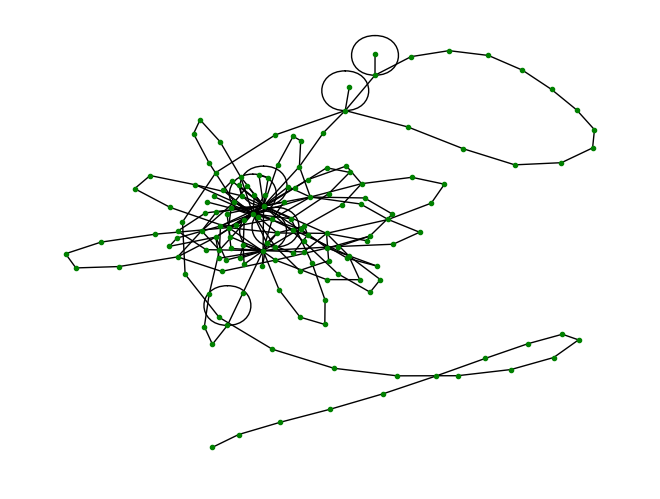

In [82]:
#Plote do grafo

G = nx.Graph()

for i in range(len(df_new)):
    if i+1 < len(df):
        origem = df['location_id'][i]
        destino = df['location_id'][i+1]
        G.add_edge(origem, destino)

nx.draw(G, node_color='green', node_size=9)

In [99]:
#Plotar o novo mapa

#ideia: se o usuário tiver mais de um check-in, plotar uma linha entre os marcadores
#exemplo: id_user = 445

lat = df_new['latitude'][0]
long = df_new['longitude'][0]

mapa = folium.Map(location = [lat, long])
coordinates = []

'''
for i in range(len(df_new)):
    iframe = folium.IFrame(str(i))
    #iframe = folium.IFrame(str(df_sorted['time'][i]))
    popup = folium.Popup(iframe, min_width=200, max_width=200)
    folium.Marker(location=[df_new['latitude'][i], df_new['longitude'][i]], popup=popup).add_to(mapa)
    coord_aux = []
    coord_aux.append(df_new['latitude'][i])
    coord_aux.append(df_new['longitude'][i])
    coordinates.append(coord_aux)
'''
for i in range(len(df_new)):
    if df_new['id_user'][i] == 445:
        iframe = folium.IFrame(str(i))
        #iframe = folium.IFrame(str(df_sorted['time'][i]))
        popup = folium.Popup(iframe, min_width=200, max_width=200)
        folium.Marker(location=[df_new['latitude'][i], df_new['longitude'][i]], popup=popup).add_to(mapa)
        coord_aux = []
        coord_aux.append(df_new['latitude'][i])
        coord_aux.append(df_new['longitude'][i])
        coordinates.append(coord_aux)


line = folium.PolyLine(locations=coordinates,weight=5).add_to(mapa)

mapa

In [ ]:
#2)a)
'''
Entre os dias 01 e 02 de maio de 2010, fortes chuvas causaram graves inundações no estado norte-americano do Tennessee.
Para se ter uma ideia da tragédia, mais de 20 pessoas morreram e centenas precisaram de ser resgatadas. Sendo assim,
a rede complexa aqui modelada busca representar o histórico de check-in realizados na rede social Gowala durante os 
dois dias do desastre. 
'''

dict_items([(1, 5), (22, 1), (4, 16), (2, 116), (10, 1), (3, 4), (19, 1), (6, 4), (29, 1), (7, 3), (5, 2), (8, 1)])


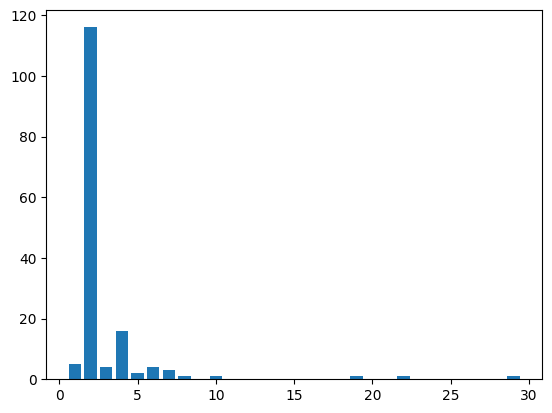

In [86]:
#2)b)
graus = []

for node, grau in G.degree():
    graus.append(grau)

num_graus = Counter(graus)
x = num_graus.keys()
y = num_graus.values()

print(num_graus.items())

plt.bar(x,y)
plt.show()
    

In [87]:
#2)c)

num_componentes = nx.number_connected_components(G)
print(num_componentes)

1


Coeficiente de clusterização médio: 0.072301


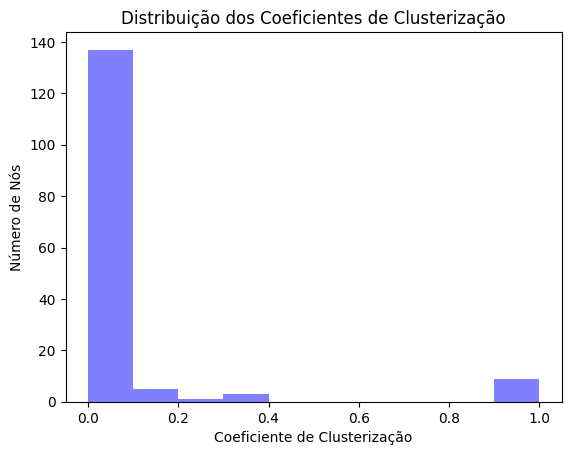

In [88]:
#2)d)
# Calcular o coeficiente de clusterização de cada nó
coeficiente_clusterizacao_medio = nx.average_clustering(G)

print("Coeficiente de clusterização médio: %f" %(coeficiente_clusterizacao_medio))

cluster_coeficientes = nx.clustering(G)

# Plotar a distribuição dos coeficientes de clusterização
plt.hist(list(cluster_coeficientes.values()), bins=10, alpha=0.5, color='b')
plt.xlabel('Coeficiente de Clusterização')
plt.ylabel('Número de Nós')
plt.title('Distribuição dos Coeficientes de Clusterização')

plt.show()

In [89]:
#2)e)
num_components = nx.number_connected_components(G)
print(num_componentes)

1


In [90]:
#2)f)
#Overlap 
# O(u,v) = (vizinho comuns de u e v) / (vizinhos de u + vizinho de v)
# O(u,v) = intercesão dos vizinhos de u e v / união dos vizinhos de u e v
 
#Verifica cada par de vértices u e v
for u in G.nodes():
    for v in G.nodes():
        #Se os vértices são distintos e não estão conectados
        if u != v and not G.has_edge(u, v):  
            vizinhos_1 = set(G.neighbors(u))
            vizinhos_2 = set(G.neighbors(v))
            
            vizinhos_comuns = vizinhos_1.intersection(vizinhos_2)
            vizinhos_todos = vizinhos_1.union(vizinhos_1)

            overlap = len(vizinhos_comuns) / len(vizinhos_todos) 
            print("Vertices: %d e %d" %(u, v))
            print(f"Overlap: ", overlap)
            print("\n")

Vertices: 864095 e 35812
Overlap:  1.0


Vertices: 864095 e 1214560
Overlap:  0.0


Vertices: 864095 e 4425307
Overlap:  0.0


Vertices: 864095 e 28439
Overlap:  0.0


Vertices: 864095 e 137805
Overlap:  1.0


Vertices: 864095 e 29069
Overlap:  1.0


Vertices: 864095 e 138992
Overlap:  0.0


Vertices: 864095 e 664053
Overlap:  0.0


Vertices: 864095 e 663944
Overlap:  0.0


Vertices: 864095 e 94178
Overlap:  0.0


Vertices: 864095 e 663957
Overlap:  0.0


Vertices: 864095 e 119619
Overlap:  0.0


Vertices: 864095 e 663817
Overlap:  0.0


Vertices: 864095 e 119534
Overlap:  0.0


Vertices: 864095 e 2190455
Overlap:  0.0


Vertices: 864095 e 132612
Overlap:  0.0


Vertices: 864095 e 35031
Overlap:  0.0


Vertices: 864095 e 253826
Overlap:  0.0


Vertices: 864095 e 33035
Overlap:  1.0


Vertices: 864095 e 222509
Overlap:  0.0


Vertices: 864095 e 155626
Overlap:  0.0


Vertices: 864095 e 45915
Overlap:  0.0


Vertices: 864095 e 452100
Overlap:  0.0


Vertices: 864095 e 26265
Overlap:  1.0

In [93]:
#2)g)
distancia_media = nx.average_shortest_path_length(G)
print("A distância média entre todos os pares de nós é %f" % (distancia_media))

dist = []
for u in G.nodes():
    for v in G.nodes():
        #Se os vértices são distintos
        if u != v:
            dist_u_v = nx.shortest_path_length(G, source=u, target=v)
            print("Distância de %d a %d: %f" % (u, v, dist_u_v))
            dist.append(dist_u_v)

print(Counter(dist))

A distância média entre todos os pares de nós é 7.354755
Distância de 864095 a 26904: 1.000000
Distância de 864095 a 35812: 2.000000
Distância de 864095 a 1214560: 3.000000
Distância de 864095 a 4425307: 4.000000
Distância de 864095 a 28439: 3.000000
Distância de 864095 a 137805: 2.000000
Distância de 864095 a 29069: 2.000000
Distância de 864095 a 138992: 3.000000
Distância de 864095 a 664053: 4.000000
Distância de 864095 a 663944: 4.000000
Distância de 864095 a 94178: 3.000000
Distância de 864095 a 663957: 3.000000
Distância de 864095 a 119619: 3.000000
Distância de 864095 a 663817: 4.000000
Distância de 864095 a 119534: 5.000000
Distância de 864095 a 2190455: 5.000000
Distância de 864095 a 132612: 4.000000
Distância de 864095 a 35031: 3.000000
Distância de 864095 a 253826: 3.000000
Distância de 864095 a 33035: 2.000000
Distância de 864095 a 222509: 3.000000
Distância de 864095 a 155626: 4.000000
Distância de 864095 a 45915: 4.000000
Distância de 864095 a 452100: 3.000000
Distância de